[[-0.7048323892719874], [-0.6977857657566573], [0.9468811119336953]]
[71.68085389387336, -90.61867591303064, 30.256863642677416]
0.2689070701599121


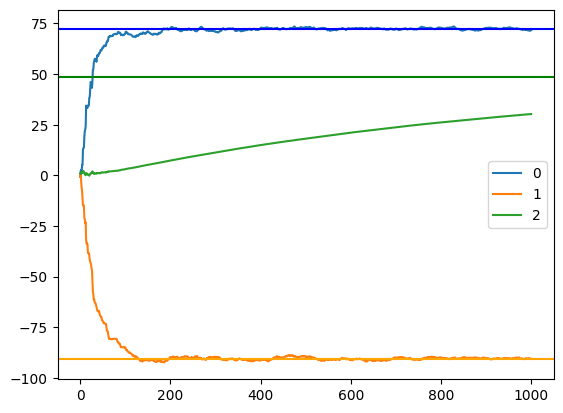

In [6]:
import numpy as np
import matplotlib as plt
from Neuron import *
import time 
import matplotlib.pyplot as plt

class Output_Layer:
    def __init__(self, input_shape, output_shape, activation_func=none):
        neuron_layer = np.array([])
        for x in range(output_shape):
            neuron_layer = np.append(neuron_layer,Perceptron(n_of_weights=input_shape, step=activation_func, activation=activation_func))
        self.neurons = neuron_layer
        
    def get_neuron(self, n):
        return self.neurons[n]
    
    def get_neurons(self):
        return self.neurons
    
    def set_neurons(self, adj_neurons):
        self.neurons = adj_neurons
    
    def forward_pass(self, X):
        output = np.array([])
        for neuron in self.neurons:
            output = np.append(output,neuron.step_pass(X))
        return output
    
    def relu(self, input):
        if input>0:
            return input
        else:
            return 0
        
    def drelu(self, input):
        if input>0:
            return 1
        else:
            return 0

    def sigmoid(self, input):
        return 1/(1+np.e**(-input))

    def dsigmoid(self, input):
        return self.sigmoid(input)*(1-self.sigmoid(input))
    
    def dactivation(self, neuron, input):
        activation = neuron.get_activation()
        if activation=='sigmoid':
            return dsigmoid(neuron.raw_pass(input))
        elif activation=='relu':
            return drelu(neuron.raw_pass(input))
        else:
            return 1
    
    def fit(self, X, y, learning_rate):
        weight_change = [[w] for w in self.get_neurons()[0].get_weights()]
        print(weight_change)
        error = [0]
        neurons = self.get_neurons()
        for k in range(len(X)):
            for n in neurons:
                weights = n.get_weights()[:-1]
                adj_weights = [weights[x]-(learning_rate*(self.forward_pass(X[k])-y[k])*self.dactivation(n,X[k])*X[k][x])[0] for x in range(len(weights))]
                adj_weights.append(n.get_weights()[-1:][0]-(learning_rate*(self.forward_pass(X[k])-y[k])*self.dactivation(n,X[k]))[0])
                n.change_weights(adj_weights)
                for x in range(len(adj_weights)):
                    weight_change[x].append(adj_weights[x])
            error.append(y[k]-n.step_pass(X[k]))
            self.set_neurons(neurons)
        return weight_change, error
    
    
## testing

start = time.time()

layer = Output_Layer(2, 1)

a = np.random.uniform(-100,100)
b = np.random.uniform(-100,100)
c = np.random.uniform(-100,100)

X = np.array([np.random.uniform(-10,10,2) for x in range(1000)])
y = [a*x[0]+b*x[1]+c for x in X]

change, err = layer.fit(X,y, learning_rate=0.001)

print(layer.get_neurons()[0].get_weights())

end = time.time()
print(end-start)

plt.plot(change[0],label='0')
plt.axhline(y=a, color='blue')
plt.plot(change[1],label='1')
plt.axhline(y=b, color='orange')
plt.plot(change[2],label='2')
plt.axhline(y=c, color='green')
plt.legend()
plt.show()

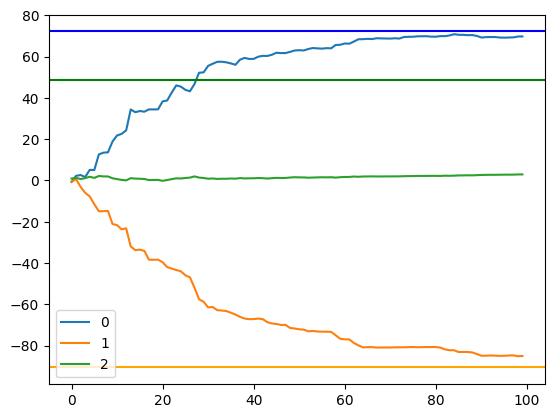

In [7]:
a1 = 0
a2 = 100
plt.plot(change[0][a1:a2],label='0')
plt.axhline(y=a, color='blue')
plt.plot(change[1][a1:a2],label='1')
plt.axhline(y=b, color='orange')
plt.plot(change[2][a1:a2],label='2')
plt.axhline(y=c, color='green')
plt.legend()
plt.show()

In [1]:
import numpy as np
import matplotlib as plt
from Dense_Layer import *
from Output_Layer import *
from Neuron import *

class Model:
    def __init__(self, Layers):
        self.Layers = Layers
        
    def get_Layers(self):
        return self.Layers
    
    def set_Layer(self, new_layer, layer_index):
        self.Layers[layer_index] = new_layer
    
    def forward_pass(self, X):
        output = X
        for layer in self.get_Layers():
            output = layer.forward_pass(output)
        return output
    
    def layer_output(self, X, layer_num):
        output = X
        for layer in self.get_Layers()[:layer_num]:
            output = layer.forward_pass(output)
        return output
    
    def dactivation(self, neuron, input):
        activation = neuron.get_activation()
        if activation=='sigmoid':
            return dsigmoid(neuron.raw_pass(input))
        elif activation=='relu':
            return drelu(neuron.raw_pass(input))
        else:
            return 1
    
    def fit(self, X, y, learning_rate):
        error = []
        for x in range(len(X)):
            # 2d array of gradients for each layer
            layer_change_weights = []
            # derivatives of the last layer
            output_layer = self.get_Layers()[-1:][0]
            output_neurons = output_layer.get_neurons()
            prev_layer = self.get_Layers()[len(self.get_Layers())-2]
            for n in output_neurons:
                weights = n.get_weights()[:-1]
                prev_output = self.layer_output(X[x], len(self.get_Layers())-1)
                adj_weights = [weights[i]-(learning_rate*(self.forward_pass(X[x])-y[x])*output_layer.dactivation(n,X[x])*prev_output[i])[0] for i in range(len(weights))]
                adj_weights.append(n.get_weights()[-1:][0]-(learning_rate*(self.forward_pass(X[x])-y[x])*output_layer.dactivation(n,X[x]))[0])
                n.change_weights(adj_weights)
                layer_change_weights.append(adj_weights)
            output_layer.set_neurons(output_neurons)
            self.set_Layer(output_layer, len(self.get_Layers())-1)
            layers = self.get_Layers()
            for k in range(len(layers)-2):
                layer = layers[len(layers)-2-k]
                new_layer_change_weights = []
                neurons = layers[len(layers)-2-k].get_neurons()
                prev_neurons = layers[len(layers)-1-k].get_neurons()
                prev_output = self.layer_output(X[k], len(layers)-2-k)
                for j in range(len(neurons)):
                    weights = neurons[j].get_weights()[:-1]
                    d = 0
                    for l in range(len(prev_neurons)):
                        d += prev_neurons[l].get_weights()[:-1][j]*layer_change_weights[l][j]
                    d *= layers[k].dactivation(neurons[j], prev_output)
                    adj_weights = [weights[i] - (learning_rate*d*prev_output[i]) for i in range(len(weights))]
                    adj_weights.append(weights[-1:][0]-(learning_rate*d))
                    neurons[j].change_weights(adj_weights)
                    new_layer_change_weights.append(adj_weights)
                layers[len(layers)-2-k].set_neurons(neurons)
                self.set_Layer(layers[len(layers)-2-k], len(layers)-2-k)
                layer_change_weights = new_layer_change_weights
            input_layer = layers[0]
            neurons = input_layer.get_neurons()
            prev_neurons = layers[1].get_neurons()
            for j in range(len(neurons)):
                weights = neurons[j].get_weights()[:-1]
                d = 0
                for l in range(len(prev_neurons)):
                    prev_weights = prev_neurons[l].get_weights()[:-1]
                    d += prev_neurons[l].get_weights()[:-1][j]*layer_change_weights[l][j]
                d *= input_layer.dactivation(neurons[j], X[x])
                adj_weights = [weights[i] - (learning_rate*d*X[x][i]) for i in range(len(weights))]
                adj_weights.append(weights[-1:][0]-(learning_rate*d))
                neurons[j].change_weights(adj_weights)
            input_layer.set_neurons(neurons)
            self.set_Layer(input_layer, 0)
            error.append((self.forward_pass(X[x])[0]-y[x])**2)
        return error

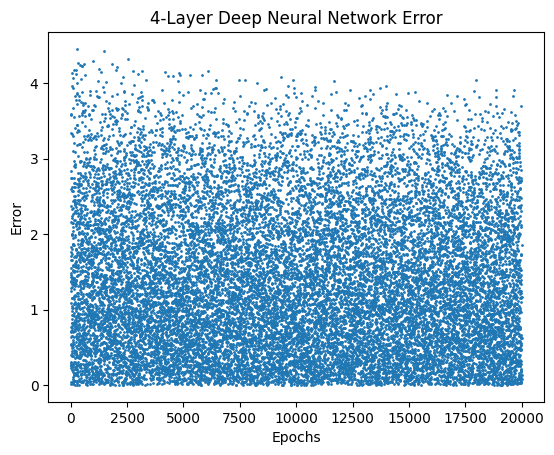

In [31]:
from Model import *

model = Model(Layers=[
    Dense_Layer(input_shape=2,output_shape=4, activation_func="relu"),
    Dense_Layer(input_shape=4,output_shape=4, activation_func="relu"),
    Dense_Layer(input_shape=4,output_shape=4, activation_func="relu"),
    Output_Layer(input_shape=4,output_shape=1)
])

X = np.random.uniform(-1, 1, size=(20000, 2))
y = [2*X[x][0]+-2*X[x][1]-1 for x in range(len(X))]

error = model.fit(X,y,learning_rate=0.0001)
plt.scatter(range(len(error)),error, s=1)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(model.get_Layers())))
plt.show()

In [32]:
error = [x[0] for x in error]

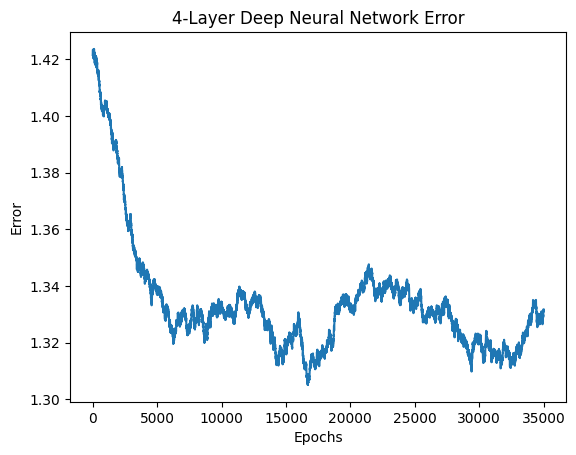

In [33]:
X = np.random.uniform(-1, 1, size=(20000, 2))
y = [2*X[x][0]+-2*X[x][1]-1 for x in range(len(X))]
a = model.fit(X,y,learning_rate=0.0001)
error = error + [a[x][0] for x in range(len(a))]
moving_average = np.convolve(error, np.ones(5000)/5000, mode='valid')
plt.plot(moving_average)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(model.get_Layers())))
plt.show()

In [34]:
import tensorflow as tf

tf_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=4, input_shape=(2,), activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
])

tf_model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])